# Auto Encoder + GAN
- Dataset: TinyImageNet <http://cs231n.stanford.edu/tiny-imagenet-200.zip>
- 200 class. 500 image per class.
- Input 32 x 32 | Output 64 x 64


## Dependencies

In [1]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image

import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
import torchvision.models as models

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

## Data Pre-Processing

### Transformations

In [2]:
transform_to_high_res = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transform_to_low_res = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [3]:
def load_tiny_imagenet_dataset(root_dir):
    lr_images = []
    hr_images = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".JPEG"):
                img_path = os.path.join(root, file)
                image = Image.open(img_path).convert("RGB")
                high_resolution = transform_to_high_res(image)
                low_resolution = transform_to_low_res(image)
                hr_images.append(high_resolution)
                lr_images.append(low_resolution)

    # Stack into tensors
    lr_tensor = torch.stack(lr_images)
    hr_tensor = torch.stack(hr_images)
    return TensorDataset(lr_tensor, hr_tensor)

In [4]:
# Loading the data into the two resolutions and using a DataLoader
"""
dataset_path = "dataset/tiny-imagenet-200/train"

dataset = load_tiny_imagenet_dataset(dataset_path)
""";

In [5]:
# To not waste time I am saving the tensors to be able to load on the go again
def save_preprocessed_tensors(dataset, save_dir="processed_data"):
    os.makedirs(save_dir, exist_ok=True)

    low_res_tensors, high_res_tensors = dataset.tensors
    
    torch.save(low_res_tensors, os.path.join(save_dir, "low_resolution.pt"))
    torch.save(high_res_tensors, os.path.join(save_dir, "high_resolution.pt"))
    print(f"Saved low-res: {low_res_tensors.shape} and high-res: {high_res_tensors.shape} to '{save_dir}'")

In [6]:
#save_preprocessed_tensors(dataset)

### Dataset Loader
- Load the saved tensor

In [7]:
def load_preprocessed_tensors(data_dir="processed_data", batch_size=256, shuffle=True, num_workers=2):
    lr_path = os.path.join(data_dir, "low_resolution.pt")
    hr_path = os.path.join(data_dir, "high_resolution.pt")

    #norm_ = v2.Normalize(mean=[0.485, 0.456, 0.406],
                         #std =[0.229, 0.224, 0.225])
    
    lr_tensor = torch.load(lr_path)
    hr_tensor = torch.load(hr_path)

    #lr_tensor = norm_(lr_tensor)
    #hr_tensor = norm_(hr_tensor)

    dataset = TensorDataset(lr_tensor, hr_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    print(f"Loaded : {len(dataset)} samples from '{data_dir}'")
    return dataloader

In [8]:
dataloader = load_preprocessed_tensors()

Loaded : 100000 samples from 'processed_data'


## Generator

In [9]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)

In [10]:
# Generator: 32x32 -> 64x64
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), # 16 -> 8
            nn.LeakyReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2.0), # 8 -> 16
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), 
            nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2.0), # 16 -> 32
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(), 
            nn.Upsample(scale_factor=2.0), # 32 -> 64
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        layers = [
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),
        ]

        channels = [64, 128, 256, 512]
        strides = [2, 2, 1]
        for i in range(3):
            layers += [
                nn.Conv2d(channels[i], channels[i+1], 4, strides[i], 1),
                nn.InstanceNorm2d(channels[i+1]),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(512, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)

In [12]:
generator = Generator()
discriminator = Discriminator()

## Training

In [38]:
def train(generator, discriminator, dataloader, num_epochs = 10, device = "cuda"):
    print("Training started")
    
    generator.to(device)
    discriminator.to(device)

    adv_losses = []
    rec_losses = []
    g_losses = []

    d_losses = []
    
    # Loss Function
    adversarial_loss = nn.BCELoss() # For discriminator
    pixel_loss = nn.MSELoss() # For Generator

    # Optimizers
    optimizer_G = optim.AdamW(generator.parameters(), lr=0.0001, betas = (0.5, 0.999))
    optimizer_D = optim.AdamW(discriminator.parameters(), lr=0.0001, betas = (0.5, 0.999))

    # Scheduler
    scheduler_G =  optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=num_epochs)
    scheduler_D =  optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=num_epochs)

    for epoch in range(num_epochs):
        g_cumul_loss = 0
        d_cumul_loss = 0
        
        for batch_idx, (lr_imgs, hr_imgs) in enumerate(dataloader):
            batch_size = lr_imgs.size(0)

            # To CUDA
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            
            # === Training the Discriminator ===
            optimizer_D.zero_grad()

            outputs_real = discriminator(hr_imgs)

            real_labels = torch.ones_like(outputs_real, device=device)
            fake_labels = torch.zeros_like(outputs_real, device=device)

            gen_hr = generator(lr_imgs)
            outputs_fake = discriminator(gen_hr.detach())
            
            loss_real = adversarial_loss(outputs_real, real_labels)
            loss_fake = adversarial_loss(outputs_fake, fake_labels)
            
            d_loss = (loss_real + loss_fake)/2
            
            d_losses.append(d_loss.item())
            d_cumul_loss+= d_loss.item()
            
            d_loss.backward()
            optimizer_D.step()
            
            
            # === Training the Generator ===
            optimizer_G.zero_grad()

            generator_outputs = discriminator(gen_hr)
            g_adv_loss = adversarial_loss(generator_outputs, real_labels) * 0.01
            g_rec_loss = pixel_loss(gen_hr, hr_imgs)

            adv_losses.append(g_adv_loss.item())
            rec_losses.append(g_rec_loss.item())
            
            g_loss = g_adv_loss + g_rec_loss

            g_losses.append(g_loss.item())
            g_cumul_loss += g_loss.item()

            g_loss.backward()
            optimizer_G.step()
            
            
            # === Cool little animation of loss curves ===
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(adv_losses, label="Adverserial Loss")
            plt.plot(rec_losses, label="Reconstruction Loss")
            plt.plot(g_losses, label="Generator Loss")
            plt.plot(d_losses, label="Discriminator Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.title("Training Loss Curves")
            plt.legend()
            plt.grid(True)
            plt.show()
            plt.close()

        scheduler_G.step()
        scheduler_D.step()

        print(f"Epoch {epoch+1} complete.")

In [39]:
train(generator, discriminator, dataloader, num_epochs = 5)

KeyboardInterrupt: 

In [40]:
with torch.no_grad():
    for lr_imgs, hr_imgs in dataloader:
        lr_imgs = lr_imgs.to("cuda")
        hr_imgs = hr_imgs.to("cuda")
        fake_imgs = generator(lr_imgs)
        break

In [41]:
def visualize_results(lr_batch, fake_batch, hr_batch, n=4):
    lr_batch = lr_batch.cpu()
    fake_batch = fake_batch.cpu()
    hr_batch = hr_batch.cpu()

    fig, axs = plt.subplots(n, 3, figsize=(9, 3 * n))
    for i in range(n):
        axs[i, 0].imshow(lr_batch[i].permute(1, 2, 0))
        axs[i, 0].set_title("Low-Res Input")
        axs[i, 1].imshow(fake_batch[i].permute(1, 2, 0))
        axs[i, 1].set_title("Generated (SR)")
        axs[i, 2].imshow(hr_batch[i].permute(1, 2, 0))
        axs[i, 2].set_title("Ground Truth")

        for j in range(3):
            axs[i, j].axis("off")

    plt.tight_layout()
    plt.show()

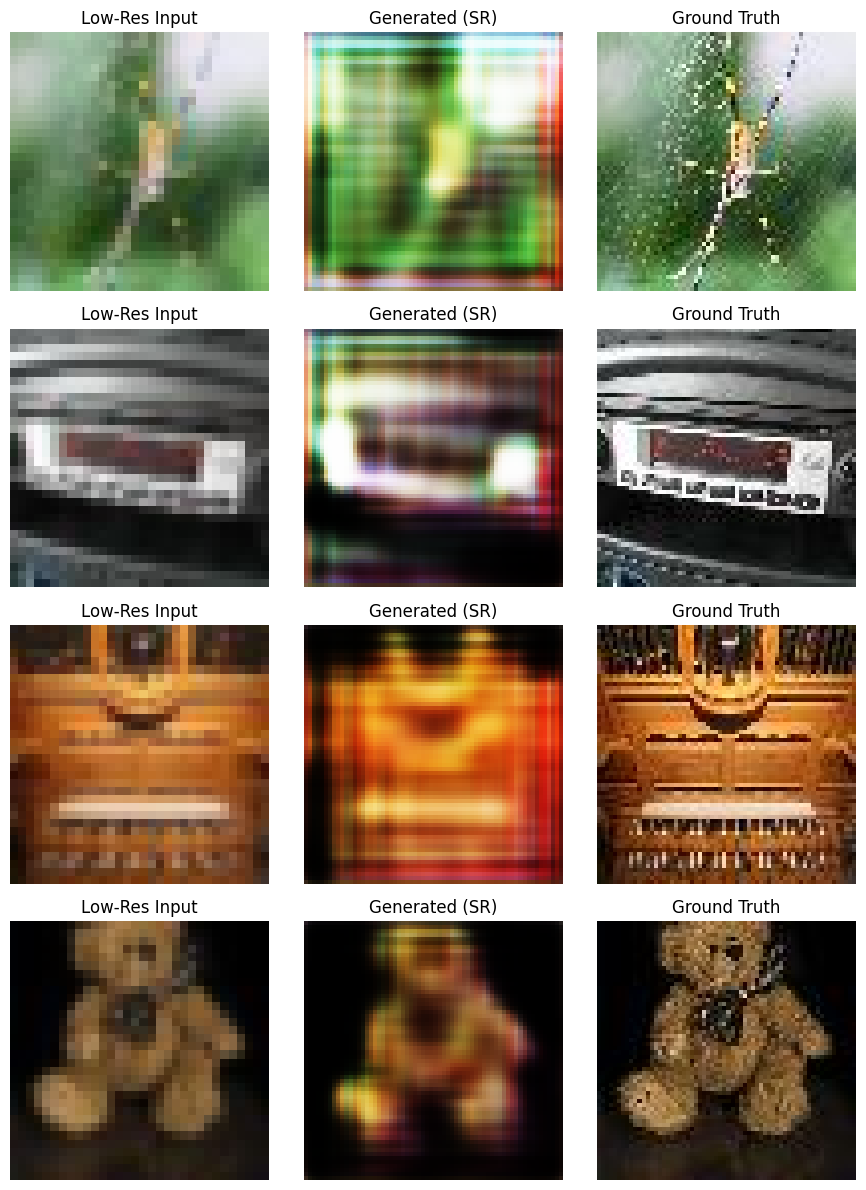

In [42]:
visualize_results(lr_imgs, fake_imgs, hr_imgs)